# Demo LoFTR-DS on a single pair of images

This notebook shows how to use the loftr matcher with default config(dual-softmax) and the pretrained weights.

In [1]:
import os
os.chdir("..")
from copy import deepcopy

import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure
import tensorwatch as tw

In [2]:
from src.loftr import LoFTR, default_cfg
from torch.onnx.utils import select_model_mode_for_export
from src.loftr.backbone import build_backbone
# a = matcher['backbone']
backbone = build_backbone(default_cfg)
print(backbone)
# backbone = build_backbone(config)
# matcher = LoFTR(config=default_cfg)
# tw.draw_model(backbone,(128, 1, 7, 7))
# matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])

ResNetFPN_8_2(
  (conv1): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2

## Indoor Example

In [ ]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
_default_cfg = deepcopy(default_cfg)
_default_cfg['coarse']['temp_bug_fix'] = True  # set to False when using the old ckpt
matcher = LoFTR(config=_default_cfg)
matcher.load_state_dict(torch.load("weights/indoor_ds_new.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [ ]:
# Load example images
img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}
# export_onnx_file = "/home/yan/code/LoFTR/viz_results/test.onnx"
# torch.onnx.export(matcher
#                     ,batch,
#                     export_onnx_file,
#                     opset_version=10,
#                     do_constant_folding=True,	# 是否执行常量折叠优化
#                     input_names=["input"],	# 输入名
#                     output_names=["output"],	# 输出名
#                     dynamic_axes={"input":{0:"batch_size"},  # 批处理变量
#                                     "output":{0:"batch_size"}})

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

In [ ]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)

## Outdoor Example

In [3]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
# matcher.load_state_dict(torch.load("/home/yan/code/LoFTR/logs/tb_logs/outdoor-ds-640-bs=4/version_2/checkpoints/epoch=49-auc@5=0.026-auc@10=0.067-auc@20=0.123.ckpt")['state_dict'])
matcher.load_state_dict(torch.load("/home/yan/code/LoFTR/weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [4]:
default_cfg['coarse']

{'d_model': 256,
 'd_ffn': 256,
 'nhead': 8,
 'layer_names': ['self',
  'cross',
  'self',
  'cross',
  'self',
  'cross',
  'self',
  'cross'],
 'attention': 'linear',
 'temp_bug_fix': False}

In [13]:
# Load example images
img0_pth = "/home/yan/code/3DGR/multi/query/2.jpg"
img1_pth = "/home/yan/code/3DGR/multi/render/2.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8))  # input size shuold be divisible by 8
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

# img0_raw = cv2.resize(img0_raw, (640, 640))  # input size shuold be divisible by 8
# img1_raw = cv2.resize(img1_raw, (640, 640))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

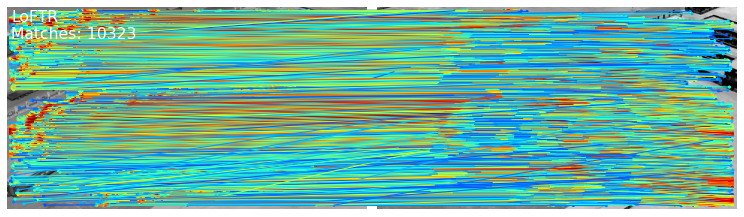

In [14]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)